# Skills Detection - Análise Exploratória

Análise das skills detectadas nas vagas de Data Engineer.

In [1]:
import sys
sys.path.insert(0, '../../src')

import json
import pandas as pd
from collections import Counter

from skills_detection.skill_matcher import SkillMatcher, CATALOG_VERSION

## 1. Carregar Dados

In [2]:
# Carregar catálogo de skills (JSON - mesmo formato usado em produção)
with open('../../src/skills_detection/config/skills_catalog.json') as f:
    catalog = json.load(f)

matcher = SkillMatcher.from_dict(catalog, CATALOG_VERSION)
print(f"Catálogo carregado: {len(matcher.skills)} skills")

Catálogo carregado: 173 skills


In [3]:
# Carregar dados do Silver (parquet)
df = pd.read_parquet('../../tmp/')
print(f"Registros: {len(df)}")
print(f"Colunas: {list(df.columns)}")

Registros: 36
Colunas: ['job_unique_id', 'job_posting_id', 'source_system', 'url', 'scraped_at', 'company_name', 'company_id', 'company_url', 'job_title', 'job_seniority_level', 'job_function', 'job_employment_type', 'job_industries', 'job_location', 'country_code', 'job_posted_datetime', 'job_posted_date_only', 'application_availability', 'apply_link', 'job_num_applicants', 'salary_min', 'salary_max', 'salary_currency', 'salary_period', 'job_poster_name', 'job_poster_title', 'job_poster_url', 'job_summary', 'job_description_html', 'job_description_text']


In [4]:
df.head()

,job_unique_id,job_posting_id,source_system,url,scraped_at,company_name,company_id,company_url,job_title,job_seniority_level,...,salary_min,salary_max,salary_currency,salary_period,job_poster_name,job_poster_title,job_poster_url,job_summary,job_description_html,job_description_text
0,None,None,linkedin,None,2025-12-03 05:00:31.486,None,None,None,None,None,...,NaN,NaN,None,None,None,None,None,None,None,None
1,4319177210,4319177210,linkedin,https://www.linkedin.com/jobs/view/azure-data-...,2025-12-03 05:00:28.966,"Gravity Infosolutions, Inc.",13229095,https://www.linkedin.com/company/gravityinfoso...,Azure Data Services Engineer - MS Fabric - Con...,Associate,...,NaN,NaN,None,None,None,None,None,Position: Azure Data Engineer – Microsoft Fabr...,"<section class=""show-more-less-html"" data-max-...",Position: Azure Data Engineer &#x2013; Micros...
2,4324975927,4324975927,linkedin,https://www.linkedin.com/jobs/view/denodo-data...,2025-12-03 05:00:29.931,ITbility,3336599,https://au.linkedin.com/company/itbility?trk=p...,Denodo Data Engineer,Mid-Senior level,...,NaN,NaN,None,None,None,None,None,Denodo Data Engineer 12 months + Melbourne My ...,"<section class=""show-more-less-html"" data-max-...",Denodo Data Engineer 12 months + Melbourne My...
3,4325288499,4325288499,linkedin,https://www.linkedin.com/jobs/view/data-engine...,2025-12-03 05:00:28.536,Sarya Connective Global Private Limited,109003259,https://in.linkedin.com/company/sarya-connecti...,Data Engineer,Entry level,...,NaN,NaN,None,None,None,None,None,Company Description Sarya Connective Global Pr...,"<section class=""show-more-less-html"" data-max-...",Company Description Sarya Connective Global P...
4,4325473153,4325473153,linkedin,https://www.linkedin.com/jobs/view/data-engine...,2025-12-03 05:00:29.970,IQVIA,4057,https://www.linkedin.com/company/iqvia?trk=pub...,Data Engineer (EU nationals only),Mid-Senior level,...,NaN,NaN,None,None,None,None,None,Only EU Citizens are eligible to apply for thi...,"<section class=""show-more-less-html"" data-max-...",Only EU Citizens are eligible to apply for th...


## 2. Aplicar Detecção de Skills

In [5]:
def detect_skills_row(row):
    """Detecta skills em uma linha do DataFrame."""
    title = str(row.get('job_title') or '')
    desc = str(row.get('job_description_text') or '')
    text = f"{title} {desc}"
    return matcher.detect(text)

# Aplicar detecção
df['skills_result'] = df.apply(detect_skills_row, axis=1)

# Extrair colunas
df['skills_canonical'] = df['skills_result'].apply(lambda x: x['skills_canonical'])
df['skills_families'] = df['skills_result'].apply(lambda x: x['skills_families'])
df['skills_count'] = df['skills_canonical'].apply(len)

print(f"Skills detectadas em {len(df[df['skills_count'] > 0])} de {len(df)} vagas ({len(df[df['skills_count'] > 0])/len(df)*100:.0f}%)")

Skills detectadas em 35 de 36 vagas (97%)


## 3. Análise de Frequência de Skills

In [6]:
# Todas as skills encontradas
all_skills = [skill for skills in df['skills_canonical'] for skill in skills]
skill_counts = Counter(all_skills)

# Top 20 skills
top_skills = pd.DataFrame(skill_counts.most_common(20), columns=['skill', 'count'])
top_skills['percentage'] = (top_skills['count'] / len(df) * 100).round(1)
top_skills

,skill,count,percentage
0,Azure,27,75.0
1,Apache Spark,26,72.2
2,Data Quality,25,69.4
3,ETL,25,69.4
4,Python,22,61.1
5,Agile,19,52.8
6,Communication,17,47.2
7,CI/CD,16,44.4
8,Databricks,15,41.7
9,SQL,14,38.9


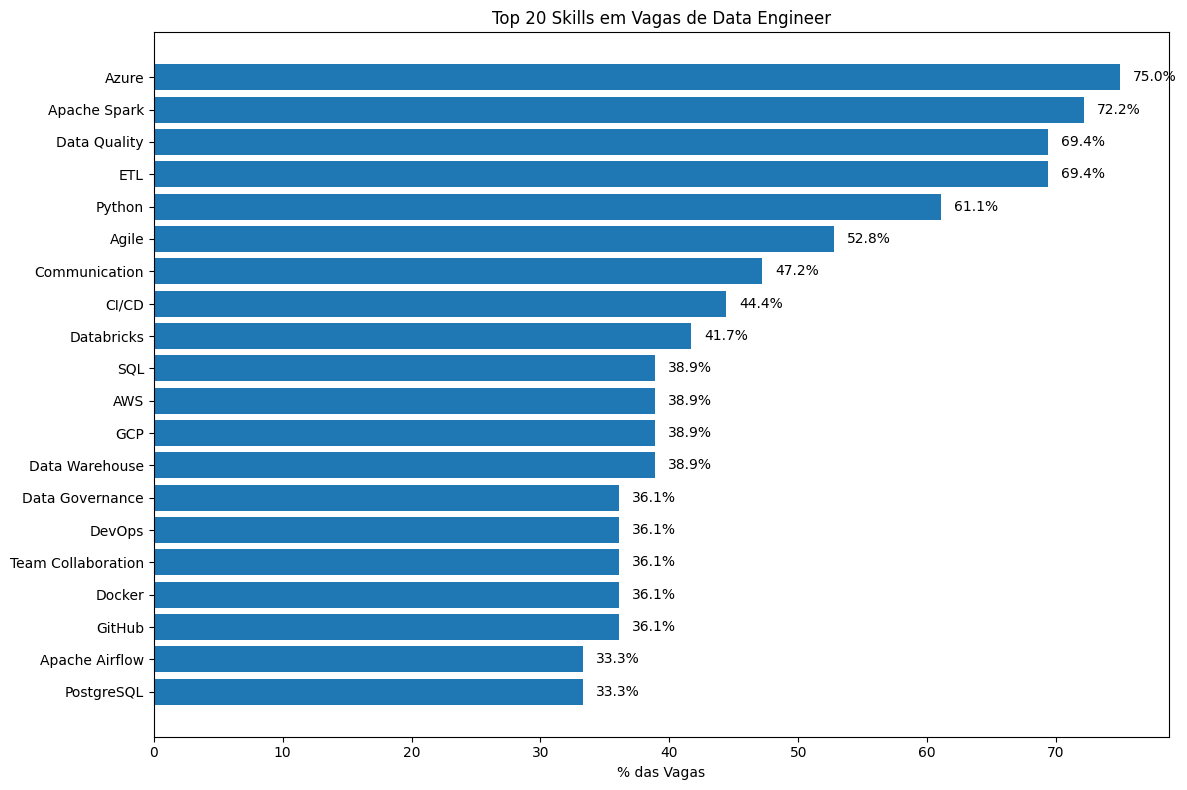

In [7]:
# Visualização
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(top_skills['skill'][::-1], top_skills['percentage'][::-1])
ax.set_xlabel('% das Vagas')
ax.set_title('Top 20 Skills em Vagas de Data Engineer')

# Adicionar labels
for bar, pct in zip(bars, top_skills['percentage'][::-1]):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct}%', va='center')

plt.tight_layout()
plt.show()

## 4. Análise por Família de Skills

In [8]:
# Todas as famílias
all_families = [fam for families in df['skills_families'] for fam in families]
family_counts = Counter(all_families)

family_df = pd.DataFrame(family_counts.most_common(), columns=['family', 'count'])
family_df['percentage'] = (family_df['count'] / len(df) * 100).round(1)
family_df

,family,count,percentage
0,cloud_platforms,32,88.9
1,practices,31,86.1
2,governance_quality,28,77.8
3,data_processing,27,75.0
4,programming_languages,24,66.7
5,soft_skills,19,52.8
6,data_warehouses,18,50.0
7,devops_tools,17,47.2
8,databases,17,47.2
9,version_control,16,44.4


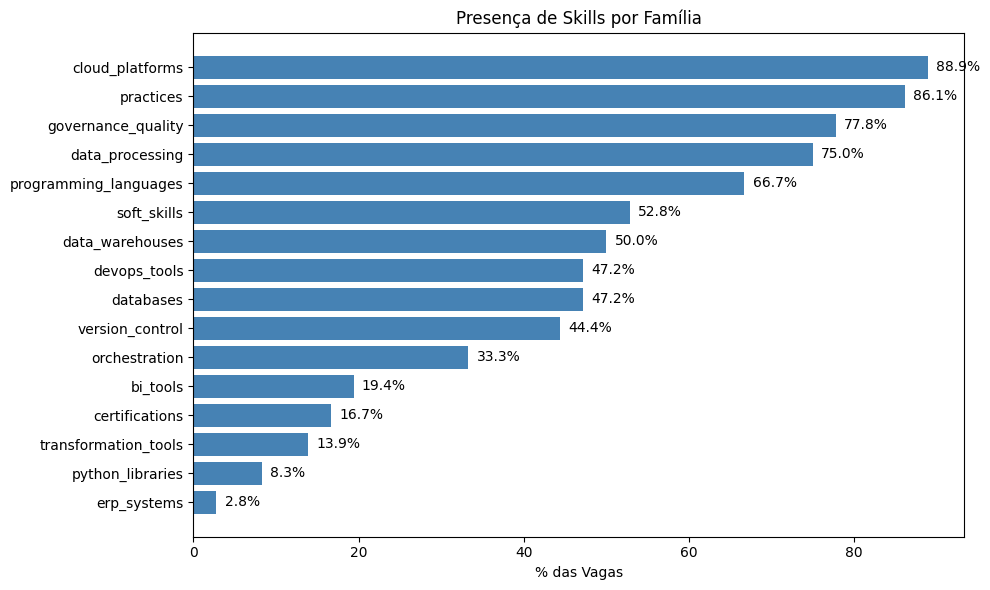

In [9]:
# Visualização por família
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(family_df['family'][::-1], family_df['percentage'][::-1], color='steelblue')
ax.set_xlabel('% das Vagas')
ax.set_title('Presença de Skills por Família')

for bar, pct in zip(bars, family_df['percentage'][::-1]):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct}%', va='center')

plt.tight_layout()
plt.show()

In [10]:
# Top 3 skills por família
skill_family_map = {s.canonical: s.family for s in matcher.skills}

skills_with_family = []
for skills in df['skills_canonical']:
    for skill in skills:
        family = skill_family_map.get(skill, 'unknown')
        skills_with_family.append({'skill': skill, 'family': family})

skills_family_df = pd.DataFrame(skills_with_family)
top_by_family = (skills_family_df
    .groupby(['family', 'skill'])
    .size()
    .reset_index(name='count')
    .sort_values(['family', 'count'], ascending=[True, False])
    .groupby('family')
    .head(3)
)

# Pivot para visualização
for family in sorted(top_by_family['family'].unique()):
    family_data = top_by_family[top_by_family['family'] == family]
    print(f"\n{family.upper().replace('_', ' ')}:")
    for _, row in family_data.iterrows():
        pct = row['count'] / len(df) * 100
        print(f"  {row['skill']}: {row['count']} ({pct:.1f}%)")


BI TOOLS:
  Power BI: 6 (16.7%)
  Looker: 2 (5.6%)
  Tableau: 2 (5.6%)

CERTIFICATIONS:
  Azure Data Engineer Associate: 4 (11.1%)
  AWS Certified Data Analytics: 1 (2.8%)
  Google Professional Data Engineer: 1 (2.8%)

CLOUD PLATFORMS:
  Azure: 27 (75.0%)
  AWS: 14 (38.9%)
  GCP: 14 (38.9%)

DATA PROCESSING:
  Apache Spark: 26 (72.2%)
  Databricks: 15 (41.7%)
  Hadoop: 9 (25.0%)

DATA WAREHOUSES:
  Snowflake: 11 (30.6%)
  Azure Synapse Analytics: 4 (11.1%)
  Google BigQuery: 2 (5.6%)

DATABASES:
  PostgreSQL: 12 (33.3%)
  MySQL: 11 (30.6%)
  Oracle Database: 3 (8.3%)

DEVOPS TOOLS:
  CI/CD: 16 (44.4%)
  Docker: 13 (36.1%)
  GitHub Actions: 10 (27.8%)

ERP SYSTEMS:
  Microsoft Dynamics: 1 (2.8%)
  SAP: 1 (2.8%)

GOVERNANCE QUALITY:
  Data Quality: 25 (69.4%)
  Data Governance: 13 (36.1%)
  Data Lineage: 4 (11.1%)

ORCHESTRATION:
  Apache Airflow: 12 (33.3%)
  Prefect: 8 (22.2%)

PRACTICES:
  ETL: 25 (69.4%)
  Agile: 19 (52.8%)
  Data Warehouse: 14 (38.9%)

PROGRAMMING LANGUAGES:
  Pyth

## 5. Estatísticas por Vaga

In [11]:
print("Estatísticas de skills por vaga:")
print(f"  Média: {df['skills_count'].mean():.1f}")
print(f"  Mediana: {df['skills_count'].median():.0f}")
print(f"  Mínimo: {df['skills_count'].min()}")
print(f"  Máximo: {df['skills_count'].max()}")
print(f"  Desvio padrão: {df['skills_count'].std():.1f}")

Estatísticas de skills por vaga:
  Média: 16.1
  Mediana: 18
  Mínimo: 0
  Máximo: 39
  Desvio padrão: 7.8


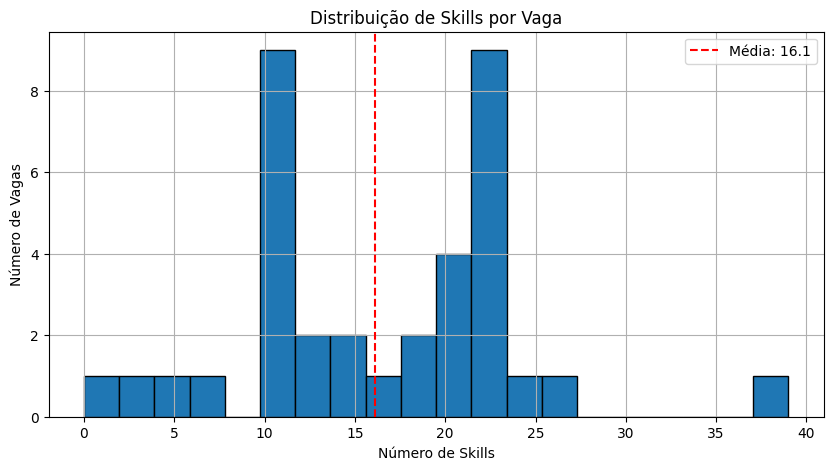

In [12]:
# Distribuição de skills por vaga
fig, ax = plt.subplots(figsize=(10, 5))
df['skills_count'].hist(bins=20, ax=ax, edgecolor='black')
ax.set_xlabel('Número de Skills')
ax.set_ylabel('Número de Vagas')
ax.set_title('Distribuição de Skills por Vaga')
ax.axvline(df['skills_count'].mean(), color='red', linestyle='--', label=f"Média: {df['skills_count'].mean():.1f}")
ax.legend()
plt.show()

## 6. Co-ocorrência de Skills

In [13]:
# Skills que aparecem juntas com frequência
from itertools import combinations

pairs = []
for skills in df['skills_canonical']:
    if len(skills) >= 2:
        for pair in combinations(sorted(skills), 2):
            pairs.append(pair)

pair_counts = Counter(pairs)
top_pairs = pd.DataFrame(pair_counts.most_common(15), columns=['pair', 'count'])
top_pairs['skill_1'] = top_pairs['pair'].apply(lambda x: x[0])
top_pairs['skill_2'] = top_pairs['pair'].apply(lambda x: x[1])
top_pairs['percentage'] = (top_pairs['count'] / len(df) * 100).round(1)
top_pairs[['skill_1', 'skill_2', 'count', 'percentage']]

,skill_1,skill_2,count,percentage
0,Apache Spark,Azure,23,63.9
1,Data Quality,ETL,22,61.1
2,Apache Spark,Data Quality,21,58.3
3,Apache Spark,ETL,21,58.3
4,Azure,Data Quality,21,58.3
5,Azure,ETL,20,55.6
6,Agile,Apache Spark,18,50.0
7,Agile,Azure,18,50.0
8,Agile,Data Quality,18,50.0
9,Agile,ETL,17,47.2


In [14]:
# Co-ocorrência de 5 skills (stacks completas)
quintuples = []
for skills in df['skills_canonical']:
    if len(skills) >= 5:
        for combo in combinations(sorted(skills), 5):
            quintuples.append(combo)

quintuple_counts = Counter(quintuples)
top_quintuples = pd.DataFrame(quintuple_counts.most_common(10), columns=['stack', 'count'])
top_quintuples['percentage'] = (top_quintuples['count'] / len(df) * 100).round(1)

print("Top 10 Stacks de 5 Skills (mais frequentes):\n")
for i, row in top_quintuples.iterrows():
    skills_str = " + ".join(row['stack'])
    print(f"{i+1}. {skills_str}")
    print(f"   Frequência: {row['count']} vagas ({row['percentage']}%)\n")

Top 10 Stacks de 5 Skills (mais frequentes):

1. Agile + Apache Spark + Azure + Data Quality + ETL
   Frequência: 17 vagas (47.2%)

2. Apache Airflow + Apache Spark + CI/CD + GitHub + Python
   Frequência: 11 vagas (30.6%)

3. Apache Airflow + Apache Spark + Data Quality + Docker + GitHub
   Frequência: 11 vagas (30.6%)

4. Apache Airflow + Apache Spark + Data Quality + Docker + Python
   Frequência: 11 vagas (30.6%)

5. Apache Airflow + Apache Spark + Data Quality + GitHub + Python
   Frequência: 11 vagas (30.6%)

6. Apache Airflow + Apache Spark + Docker + GitHub + Python
   Frequência: 11 vagas (30.6%)

7. Apache Airflow + Data Quality + Docker + GitHub + Python
   Frequência: 11 vagas (30.6%)

8. Apache Spark + Data Quality + Docker + GitHub + Python
   Frequência: 11 vagas (30.6%)

9. Data Quality + ETL + MySQL + PostgreSQL + Python
   Frequência: 11 vagas (30.6%)

10. Data Warehouse + ETL + GCP + PostgreSQL + Python
   Frequência: 11 vagas (30.6%)



## 7. Exemplo de Vagas

In [15]:
# Vaga com mais skills
top_vaga = df.loc[df['skills_count'].idxmax()]
print(f"Vaga com mais skills ({top_vaga['skills_count']}):")
print(f"  Título: {top_vaga['job_title']}")
print(f"  Empresa: {top_vaga.get('company_name', 'N/A')}")
print(f"  Skills: {', '.join(top_vaga['skills_canonical'][:15])}...")

Vaga com mais skills (39):
  Título: GCP Data Engineer
  Empresa: CustomerLabs ❤️ 1P Data OPs
  Skills: Apache Airflow, Apache Kafka, Apache Spark, Apache Superset, Azure Data Lake Storage, BigQuery, Cloud Run, Communication, Data Catalog, Data Governance, Data Lake, Data Lineage, Data Quality, Data Warehouse, Docker...
